- Export ERP to text (universal)
- Create `mne.EvokedArray()` object 

### Plotting single-subject averaged ERPs

In [1]:
import os
import mne
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import namedtuple
from warnings import filterwarnings
filterwarnings('ignore')

In [216]:
def parse_bdf(bdf_txt):
    f1 = open(bdf_txt, encoding='utf-8')
    f2 = f1.read().split()
    f1.close()
    bin_labels = [f2[2+4*i] for i in range(int((len(f2))/4))]
    
    bins = {}
    for i,x in enumerate(bin_labels):
        bins[x] = i
    return bins
    

def align_bindata_files(bins, prefix, path, start=10, end=-5, end_except=-4):
    files_orig = [[f for f in fs if f.startswith(prefix)] for root, dirs, fs in os.walk(path, topdown=True)][0]
    files = [None]*len(bins)
    for f in files_orig:
        try:
            files[bins[f[start:end]]] = f  # 10 and -5 depend on the file names
        except KeyError:
            files[bins[f[start:end_except]]] = f  # 10 and -4 depend on the file names
    return files
    

Evoked_Wrapper = namedtuple('Evoked_Wrapper',
                            ['evokeds', 'info','data','bins','ch_names','tmin','tmax'])


def evoked_wrapper_from_data(bins, path, files, tmin, info, col_to_drop=['time','Unnamed: 35'], sep='	', resample=False,
                             disp=None):
    
    print(f'Dropping columns {col_to_drop}\n')
    evokeds, data = [None]*len(files), np.empty((len(files)), dtype=np.ndarray)
    os.chdir(path)
    dfs = []
    for i, f in enumerate(files):
        try:
            df = pd.read_csv(f, sep=sep).drop(columns=col_to_drop)
            eeglab_data = df.to_numpy().transpose()
            if resample == True: eeglab_data = mne.filter.resample(eeglab_data, up=1000/info['sfreq'])
            data[i] = eeglab_data
            dfs.append(df)
        except ValueError:
            eeglab_data = np.empty(eeglab_data.shape)
            dfs.append(pd.DataFrame(data=None, index=None, columns=df.columns))
        evokeds[i] = mne.EvokedArray(data=eeglab_data, info=info, tmin=tmin)
    os.chdir('..')
    print(f'''Your bin data text files give {data[0].shape[0]} channels x {data[0].shape[1]} time points.
              (Note that the time points are the resampled time points if resampling is applied.)
              Please check if the dimension is correct...\n''')
    
    if disp != None:
        for i in disp:
            if str(i)[-1] == '1': num = str(i) + 'st'
            elif str(i)[-1] == '2': num = str(i) + 'nd'
            elif str(i)[-1] == '3': num = str(i) + 'rd'
            else: num = str(i) + 'th'
            print(f'Displaying the data file of your {num} bin in pandas.DataFrame format:\n')
            display(dfs[i-1]) if not dfs[i-1].empty else print("Ooops! You've got an empty DataFrame!\n\n")

    evoked_wrapper = Evoked_Wrapper(evokeds, info, data, bins,
                                    evokeds[0].ch_names,
                                    int(tmin*1000),int(data[0].shape[1]*1000/info['sfreq'])+int(tmin*1000))
    return evoked_wrapper


def my_plots(evoked_wrapper, layout=None, pos_dict=None, xlabel_pos=None, ylabel_pos=None,
             ch_to_plot=[], bins_to_plot=[], linestyles=[], colors=[],
             nrows=0, ncols=0, figsize=(0,0), xlim=(0,0), ylim=(0,0), xticks=[], yticks=[],
             loc='', borderpad=None, bbox_to_anchor=[],
             pad=1.08, save=False, fname=None):
    
    evokeds, info, data, bins, ch_names, tmin, tmax = evoked_wrapper
    N = data[0].shape[1]
    
    ch_dict = {}
    for i, x in enumerate(ch_names):
        ch_dict[x] = i

    t = [i for i in range(1, N+1)]
    actual_xticks = [(i-tmin)*N/(tmax-tmin) for i in xticks]

    if layout == 'Classic ERP':
        figure, axes = plt.subplots(nrows,ncols, figsize=figsize, sharey=True)
        for ax in axes.copy().flatten()[len(ch_to_plot):]:
            ax.remove()
        
        for ax, ch in zip(axes.copy().flatten()[0:len(ch_to_plot)], ch_to_plot):
            for i, x in enumerate(bins_to_plot):
                ax.plot(t, data[bins[x]][ch_dict[ch]],
                        linestyle=linestyles[i], color=colors[i], label=x)
            ax.axvline(x=abs(tmin)/(tmax-tmin)*N, color='black', linewidth=0.5)
            ax.axhline(y=0, color='black', linewidth=0.5)
            ax.set_title(ch)
            ax.set_xlabel('Time (ms)') # xlabel fontsize and labelpad not customized yet
            ax.set_xlim((xlim[0]-tmin)*N/(tmax-tmin), (xlim[1]-tmin)*N/(tmax-tmin)) 
            ax.set_xticks(actual_xticks, labels=xticks)
            ax.set_ylabel('µV') # ylabel fontsize and labelpad not customized yet
            ax.set_ylim(ylim[0], ylim[1])
            ax.set_yticks(yticks)
            ax.invert_yaxis()
            ax.yaxis.set_tick_params(labelbottom=True) # yticks label fontsize not customized yet
            hdl, lbl = ax.get_legend_handles_labels()
        figure.legend(hdl, lbl, loc=loc, borderpad=borderpad, bbox_to_anchor=bbox_to_anchor)
        figure.tight_layout(pad=pad)

    elif layout == 'Topo':
        keys, vals = list(pos_dict.keys()), list(pos_dict.values())

        figure, axes = plt.subplots(nrows, ncols, figsize=figsize, sharey=True)
        if xlabel_pos == None: xlabel_pos = (ncols-1)*nrows + int(ncols/2)
        if ylabel_pos == None: ylabel_pos = ncols*int(nrows/2)
        for (m,n), ax in np.ndenumerate(axes):
            if m*ncols+n == xlabel_pos: ax.set_xlabel('Time (ms)', fontsize=30, labelpad=35.0) # xlabel fontsize and labelpad not customized yet
            if m*ncols+n == ylabel_pos: ax.set_ylabel('µV', fontsize=30, labelpad=35.0) # ylabel fontsize and labelpad not customized yet
            try:
                if keys[vals.index(m*ncols+n)] not in ch_to_plot: ax.remove()
            except ValueError:
                ax.remove()
        
        for ch in ch_to_plot:
            ax = plt.subplot(nrows, ncols, pos_dict[ch]+1)
            for i, x in enumerate(bins_to_plot):
                ax.plot(t, data[bins[x]][ch_dict[ch]], linestyle=linestyles[i], color=colors[i], label=x)
            ax.axvline(x=abs(tmin)/(tmax-tmin)*N, color='black', linewidth=0.5)
            ax.axhline(y=0, color='black', linewidth=0.5)
            ax.set_title(ch, fontsize=40) # title fontsize not customized yet
            ax.set_xlim((xlim[0]-tmin)*N/(tmax-tmin), (xlim[1]-tmin)*N/(tmax-tmin))  
            ax.set_xticks(actual_xticks, labels=xticks)
            ax.set_ylim(ylim[0], ylim[1])
            ax.set_yticks(yticks)
            ax.invert_yaxis()  # negative up
            ax.yaxis.set_tick_params(labelbottom=True, labelsize=20)  # xticks label fontsize not customized yet
            ax.xaxis.set_tick_params(labelbottom=True, labelsize=20)  # yticks label fontsize not customized yet
            hdl, lbl = ax.get_legend_handles_labels()
        figure.legend(hdl, lbl, loc=loc, bbox_to_anchor=bbox_to_anchor, fontsize=45, borderpad=borderpad)
        figure.tight_layout(pad=pad)

    else:
        print("layout must be either 'Classic ERP' or 'Topo'!")
    
    if save == True:
        try: figure.savefig(fname)
        except AttributeError: print('Plot not saved... Please provide a valid file name to save the plot!')
        except UnboundLocalError: pass
        
    plt.show() 
    

def create_bin_op_evoked_wrapper(evoked_wrapper, bin_op_weights={}, new_binlabels=[]): # bin_op_weights is a dictionary
    evokeds, data, bins, ch_names, tmin, tmax = evoked_wrapper
    
    bin_op = [mne.combine_evoked([evokeds[bins[k.split(';')[i]]] for i in range(len(k.split(';')))], weights=v)
              for k,v in bin_op_weights.items()]
    
    data = np.empty(len(bin_op), dtype=object)
    for i,x in enumerate(bin_op):
        data[i] = x.get_data()

    new_bins = {}
    for i,x in enumerate(new_binlabels):
        new_bins[x] = i

    bin_op_evoked_wrapper = Evoked_Wrapper(bin_op, data, new_bins, evoked_wrapper.ch_names,
                                           evoked_wrapper.tmin, evoked_wrapper.tmax)
    return bin_op_evoked_wrapper


def create_contra_ipsi_evoked_wrapper(evoked_wrapper, bins_to_compare=[], groups={}):
    evokeds, data, bins, ch_names, tmin, tmax = evoked_wrapper

    contra_ipsi_evokeds = [mne.channels.combine_channels(evokeds[bins[bins_to_compare[i]]], 
                                                     groups=groups,
                                           method=lambda data: data[0]-data[1]) for i in range(len(bins_to_compare))]
    data = np.empty(len(contra_ipsi_evokeds), dtype=object)
    for i,x in enumerate(contra_ipsi_evokeds):
        data[i] = x.get_data()

    new_bins = {}
    for i,x in enumerate(bins_to_compare):
        new_bins[x] = i

    contra_ipsi_evoked_wrapper = Evoked_Wrapper(contra_ipsi_evokeds, data, new_bins, 
                                               list(groups.keys()), tmin, tmax)
    return contra_ipsi_evoked_wrapper

In [217]:
bins = parse_bdf('p3_bdf.txt')
display(bins)
print('\n')
files = align_bindata_files(bins, 'sub01_', 'avg_erp_bins', start=6, end=-5, end_except=-4)
display(files)

{'deviant': 0, 'standard': 1}

['sub01_deviant .txt', 'sub01_standard.txt']

In [218]:
os.chdir('C:\\Users\\jowan\\erpclass')

In [219]:
pwd()

'C:\\Users\\jowan\\erpclass'

In [220]:
raw = mne.io.read_raw_eeglab('sub01.set')
ch_names = raw.ch_names
ch_names = [i if 'Z' not in i else i[:-1]+'z' for i in ch_names]
ch_names[ch_names.index('FP1')], ch_names[ch_names.index('FP2')] = 'Fp1','Fp2'
'''to_exclude = ['M1','M2','HEO','VEO']'''
to_exclude = ['HEO','VEO']
# M1, M2 are not EOG; just setting them to EOG so that they don't get shown in the topo 
ch_types = ['eeg' if i not in to_exclude else 'eog' for i in ch_names]
info = mne.create_info(ch_names, ch_types=ch_types, sfreq=256.0)
# Using biosemi64 so that the electrodes won't exceed the scalp boundary
info.set_montage('biosemi64', on_missing='ignore');
print(info['sfreq'])

256.0


In [221]:
evoked_wrapper = evoked_wrapper_from_data(bins, 'avg_erp_bins', files, -0.2, info,
                              col_to_drop=['time','Unnamed: 33'], sep='	', resample=False, disp=(1,2))

display(evoked_wrapper.evokeds[0])
display(evoked_wrapper.data.shape, evoked_wrapper.data[0].shape)

Dropping columns ['time', 'Unnamed: 33']

Your bin data text files give 32 channels x 256 time points.
              (Note that the time points are the resampled time points if resampling is applied.)
              Please check if the dimension is correct...

Displaying the data file of your 1st bin in pandas.DataFrame format:



,FP1,F3,F7,FC3,C3,C5,P3,P7,P9,PO7,...,C4,C6,P4,P8,P10,PO8,PO4,O2,HEO,VEO
0,2.015982,3.173330,2.544737,2.406117,1.882892,1.470843,0.461709,1.116608,0.627945,2.612739,...,-0.198844,-1.353676,-1.431996,-2.716439,-0.627945,-4.430871,-2.047417,-2.324093,3.092078,2.488493
1,1.015287,1.681965,3.198500,1.044433,0.420586,0.924861,-1.196522,0.020941,1.942277,2.362406,...,-0.267896,-2.195410,-2.672830,-3.899478,-1.942276,-5.648770,-3.887502,-3.366838,1.864973,2.057434
2,2.314504,2.068648,3.645005,1.841870,0.964767,2.513811,-0.002198,0.784965,1.318332,-0.088330,...,-0.200587,-3.283465,-4.189550,-4.559251,-1.318332,-4.190739,-4.947661,-4.342180,-1.296099,3.708656
3,3.015878,2.804333,1.449993,2.107103,0.784173,0.403691,-0.089332,0.483406,0.952012,-1.033938,...,-0.748499,1.275421,-3.690900,-3.914986,-0.952012,-3.736036,-3.981075,-4.745211,-1.138094,3.422433
4,3.215433,2.095234,-0.390530,1.178894,0.120374,-1.648453,-0.348685,0.435632,0.444757,0.729616,...,-1.016680,-0.654280,-4.274367,-3.291163,-0.444757,-2.833532,-5.025058,-2.075328,1.062023,2.159232
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,-6.529492,-2.259557,-1.082117,-2.208963,0.323661,-1.338340,1.039413,0.912475,-1.621083,-2.733394,...,2.032146,2.827947,2.799250,3.818218,1.621083,8.538671,4.620333,2.610651,-0.576894,1.443795
252,-5.347180,-2.612064,-0.999050,-2.836374,-0.459204,-2.018569,1.096763,0.378730,-1.606349,-2.265928,...,2.468351,5.173343,3.463778,3.754173,1.606349,6.697671,5.312164,0.572596,0.369825,0.769620
253,-4.454145,-1.260043,-1.919086,-1.226727,0.821634,-0.306270,1.403172,-1.819943,-3.071895,-0.688187,...,4.183541,4.812191,4.845053,5.783912,3.071895,8.594930,6.783730,1.790098,-0.804454,-0.072195
254,-5.102147,-1.061591,-1.180399,-1.319236,0.100300,-1.791682,0.166981,-1.694005,-0.759665,-1.027754,...,2.704918,3.226372,1.424713,3.654011,0.759665,6.560938,1.393620,1.359502,-1.645479,-0.050493


Displaying the data file of your 2nd bin in pandas.DataFrame format:



,FP1,F3,F7,FC3,C3,C5,P3,P7,P9,PO7,...,C4,C6,P4,P8,P10,PO8,PO4,O2,HEO,VEO
0,0.390208,0.038776,0.446473,0.262899,0.433528,0.838460,0.586622,-0.264104,0.603040,0.101207,...,0.746300,0.652028,0.615012,-0.081893,-0.603040,-0.300066,0.648954,0.115352,0.170607,-1.675679
1,0.890976,0.301590,1.146834,0.443741,0.934590,0.931379,0.953275,2.139592,0.269469,-0.918820,...,0.848795,0.383185,0.403043,0.033357,-0.269469,1.113803,0.502381,0.511542,0.391477,-0.966328
2,-0.276786,0.061593,0.953102,-0.042371,-0.260795,-0.301463,-0.855199,-1.161729,0.926720,-0.194498,...,-0.219770,0.184017,-1.725430,-1.240944,-0.926720,-0.408967,-1.835626,-0.427186,-0.351750,-1.276668
3,-0.264906,1.345508,2.883366,1.536031,1.273334,2.292408,0.060143,-0.064301,0.310486,-0.664350,...,0.792377,0.678750,-0.726611,-0.255334,-0.310486,-0.028807,-0.506210,-0.679977,-0.774919,-1.365360
4,0.102762,0.506881,0.622150,0.619756,0.185308,0.223110,0.071245,0.724447,0.181614,-1.531793,...,0.869107,-0.172517,-0.713746,-0.359360,-0.181614,-0.623154,-1.068987,0.189070,0.301948,-1.121876
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,-2.215093,-0.939853,-1.503419,-0.375763,0.766002,0.013452,1.207882,-0.110527,-0.058467,0.848790,...,0.895387,0.833273,3.464286,2.248484,0.058467,2.070537,3.379931,1.724331,-0.110694,-1.032027
252,-1.572873,-0.030310,-0.742260,0.388623,1.437700,0.393140,2.064598,1.330507,-0.229931,0.711424,...,1.505083,0.224836,3.429384,2.651421,0.229931,2.005452,3.153171,2.355379,-0.759044,-0.630935
253,-1.364186,-0.014465,-1.340178,0.569252,1.499887,1.099259,1.479976,0.390117,-0.082803,0.666523,...,1.450747,0.553157,2.952996,1.876986,0.082803,1.476606,2.612709,2.218143,-1.089398,-0.334234
254,-0.153066,0.878421,2.003240,1.369431,2.090457,1.623252,1.635297,1.409254,-0.333853,-1.796512,...,2.395371,2.525689,3.349474,1.925806,0.333853,0.739349,3.148736,1.145670,-1.712289,-0.790636


<Evoked | '' (average, N=1), -0.19922 – 0.79688 s, baseline off, 32 ch, ~105 kB>

(2,)

(32, 256)

In [222]:
print(evoked_wrapper.tmin, evoked_wrapper.tmax)
display(evoked_wrapper.bins)

-200 800


{'deviant': 0, 'standard': 1}

Plot not saved... Please provide a valid file name to save the plot!


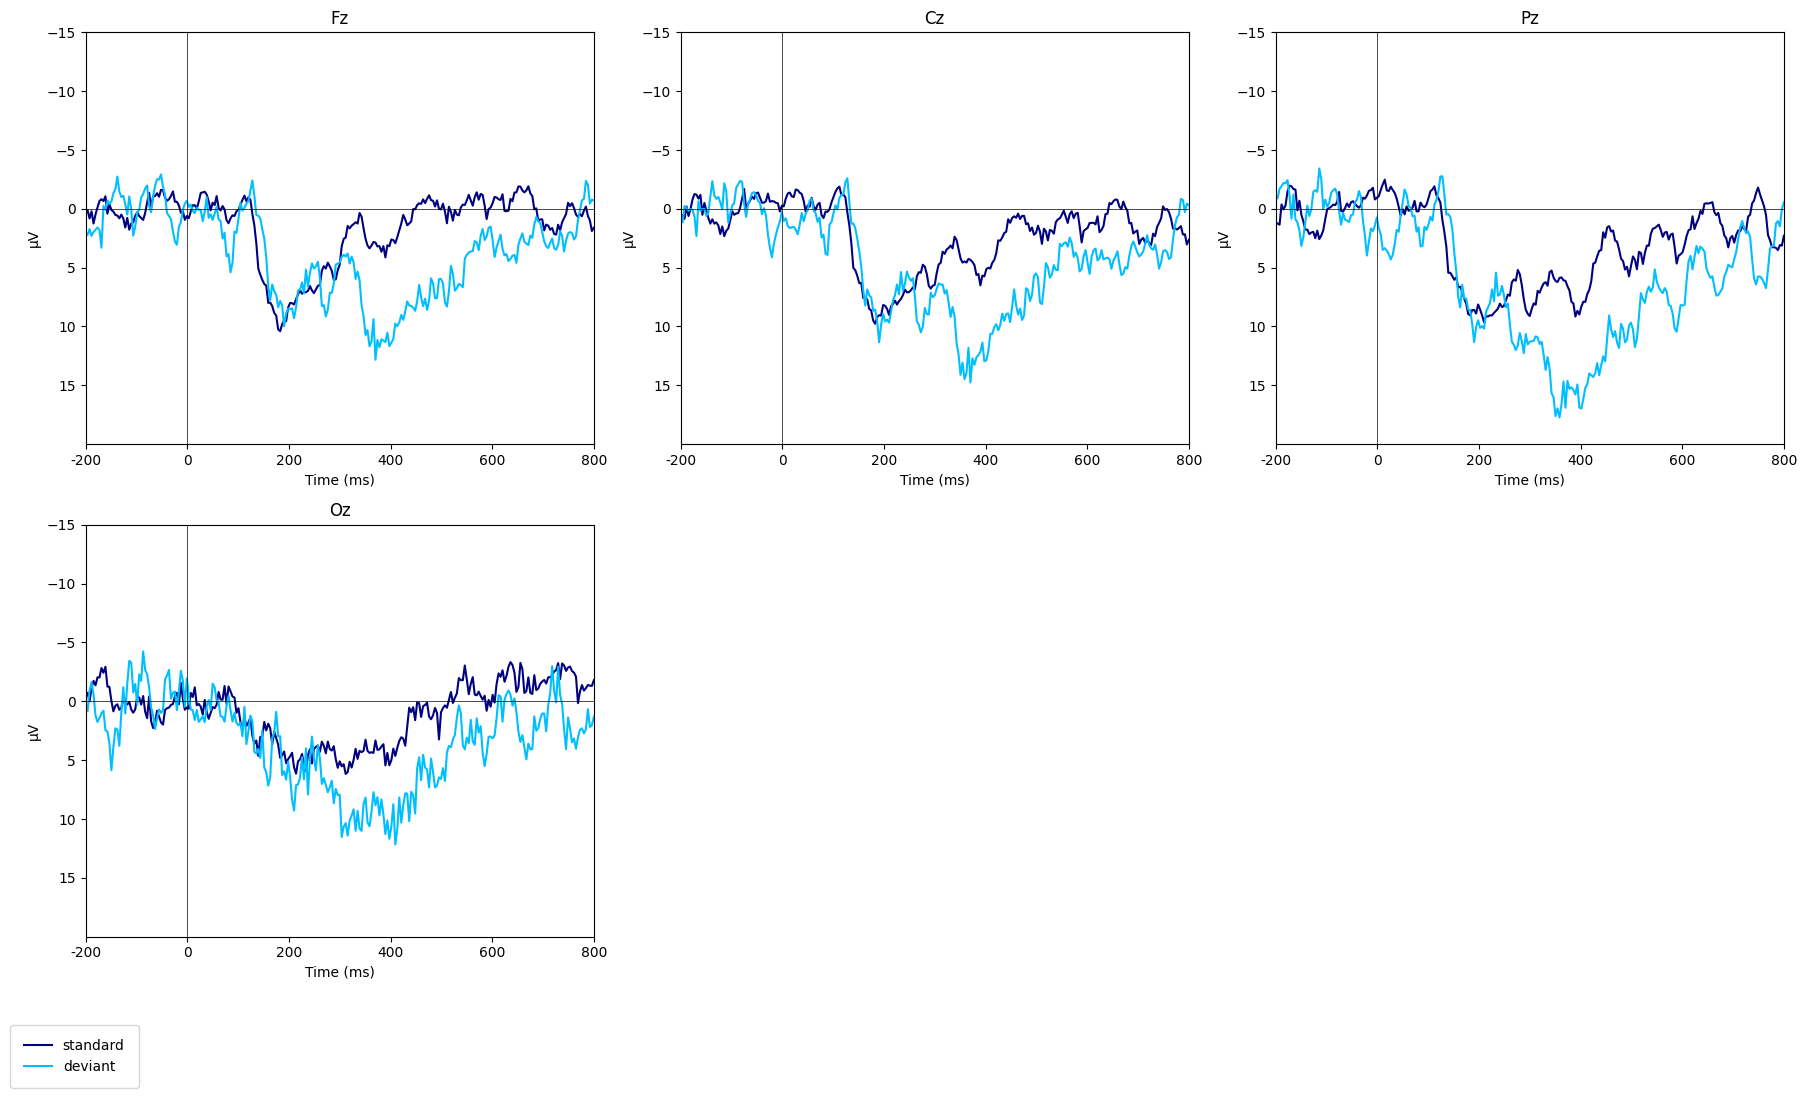

In [224]:
my_plots(evoked_wrapper, layout='Classic ERP',
        ch_to_plot=['Fz','Cz','Pz','Oz'], bins_to_plot=['standard', 'deviant'],
        linestyles=['solid', 'solid'], colors=['navy', 'deepskyblue'],
        nrows=2, ncols=3, figsize=(18,10), xlim=(-200,800), ylim=(-15,20),
        xticks=[-200,0,200,400,600,800], yticks=list(range(-15,20,5)),
        loc='lower left', borderpad=1, bbox_to_anchor=[-0.005, -0.1],
        save=True)

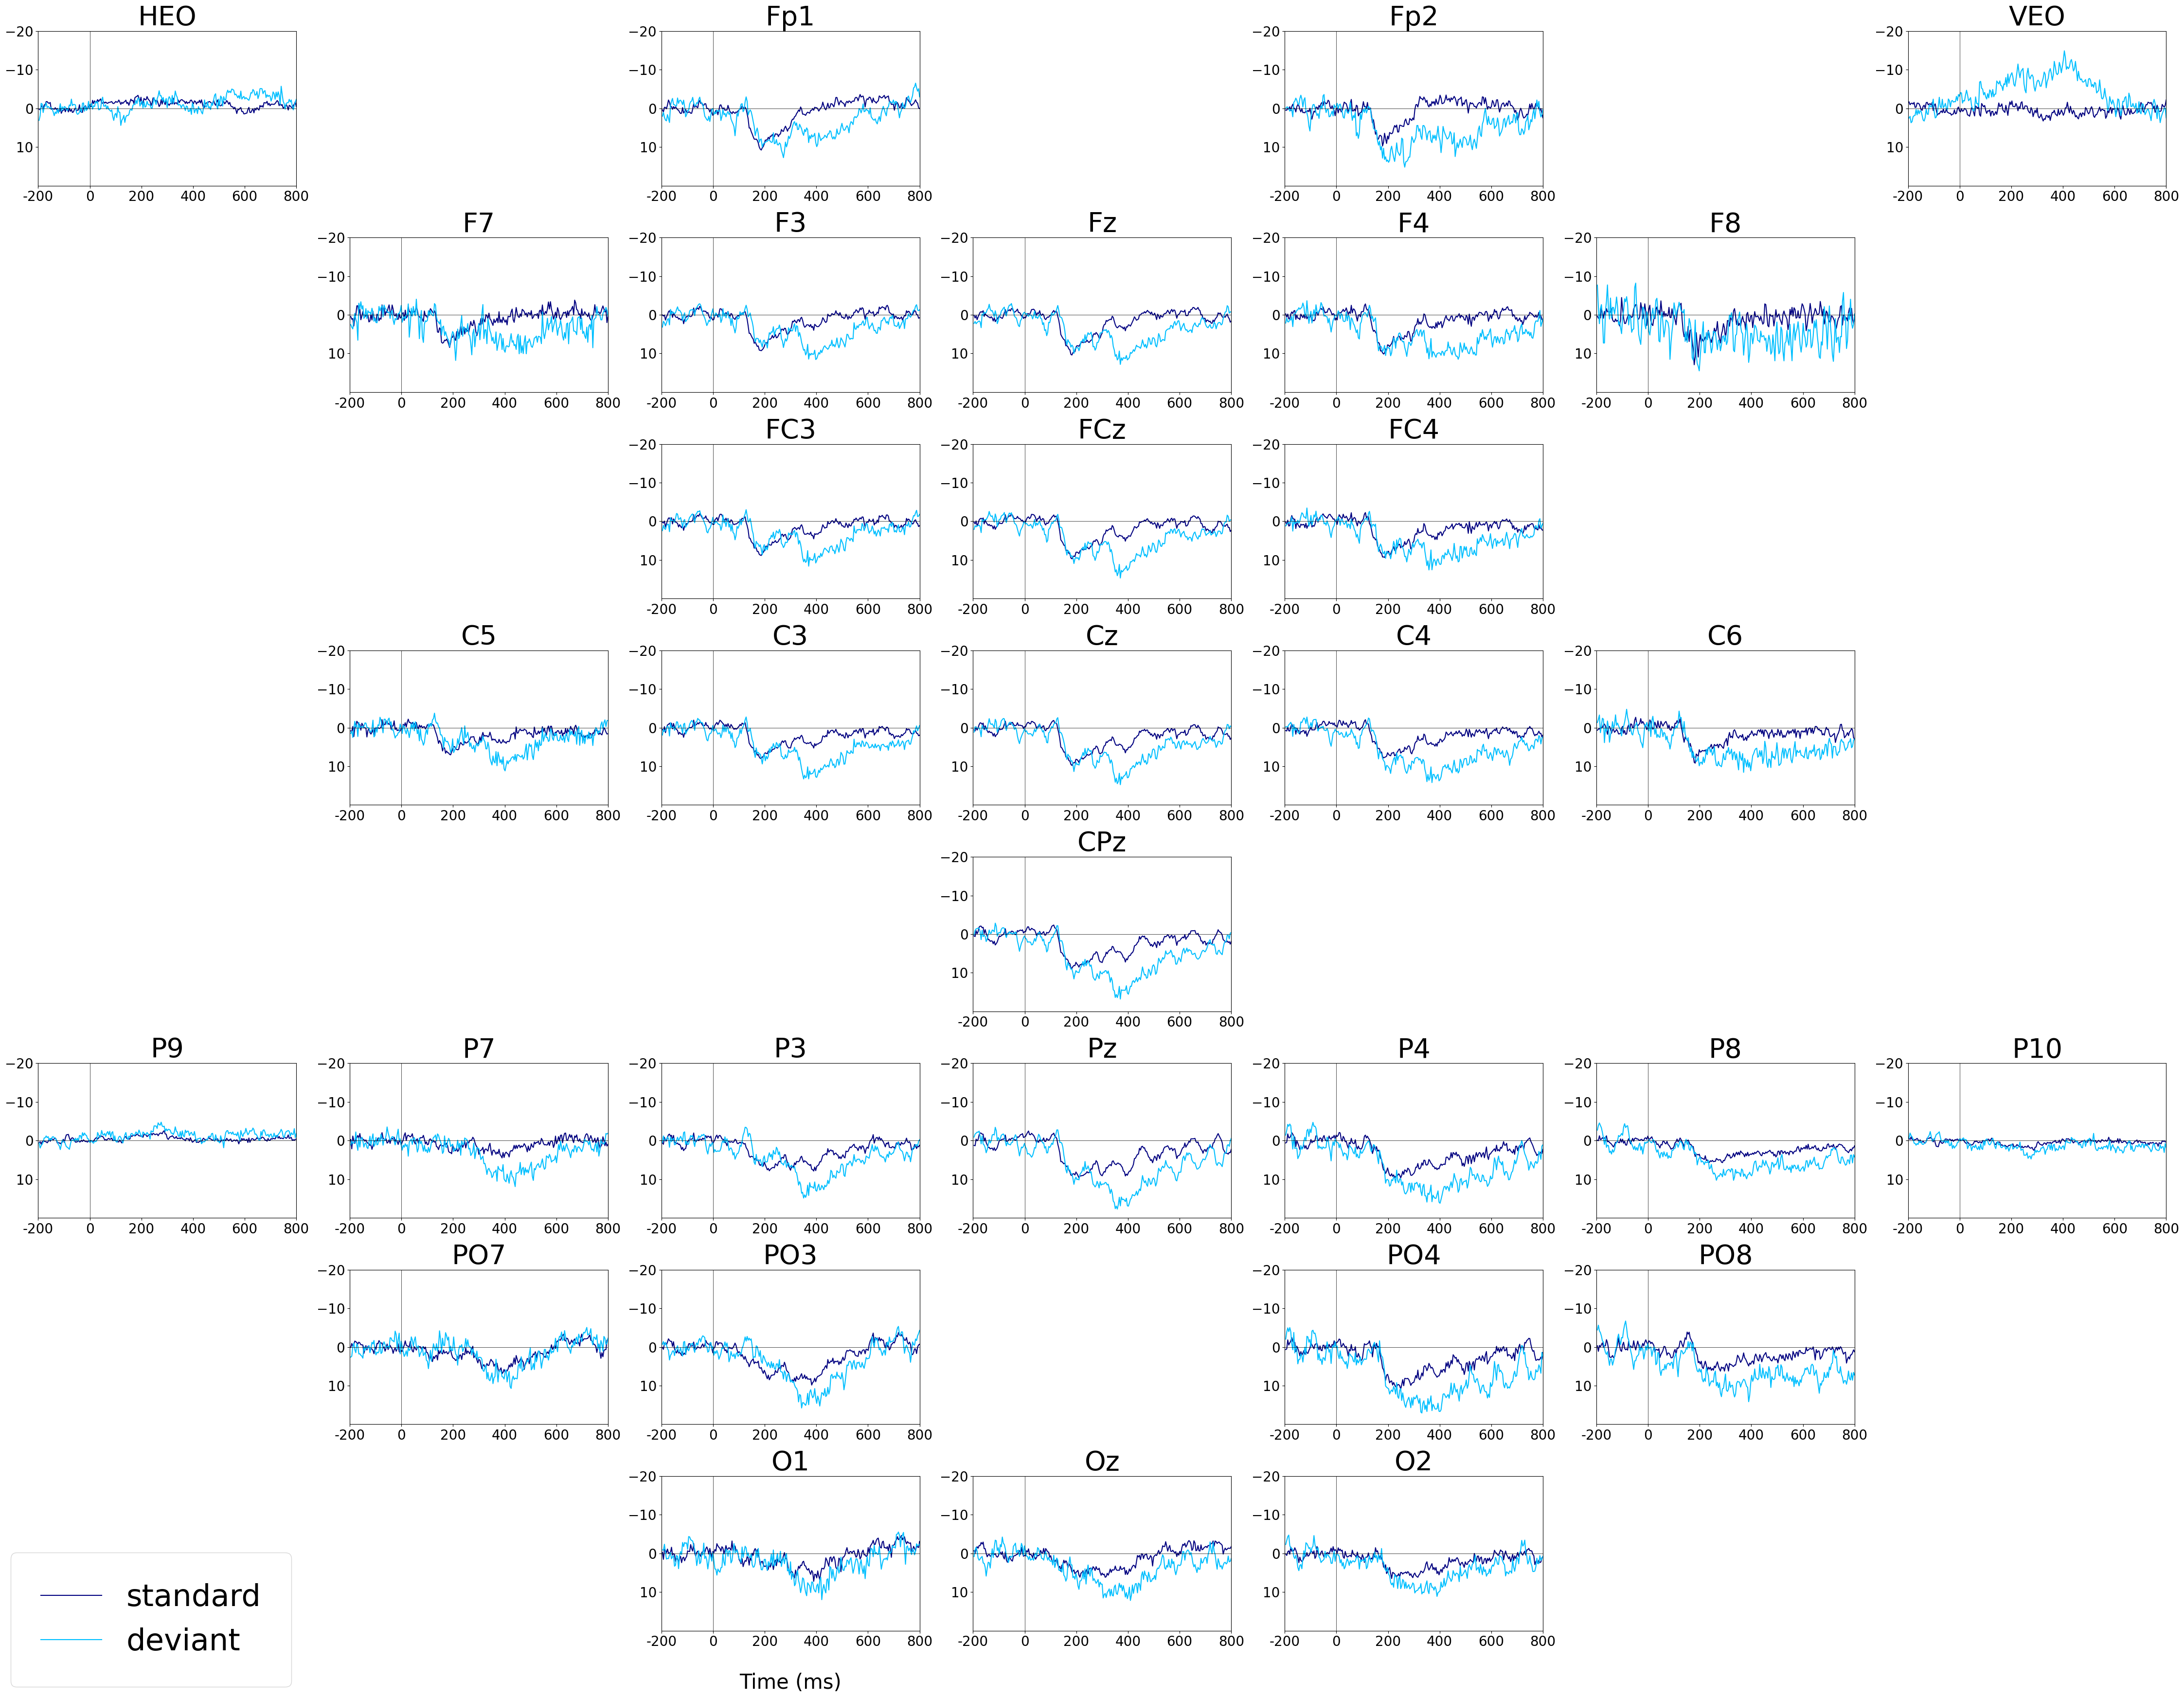

In [225]:
'''pos_dict = {'HEO':1,'Fp1':2,'Fp2':4,'VEO':5,
            'F7':8,'F3':9,'Fz':10,'F4':11,'F8':12,
            'FT7':15,'FC3':16,'FCz':17,'FC4':18,'FT8':19,
            'T7':22,'C3':23,'Cz':24,'C4':25,'T8':26,
            'M1':28,'TP7':29,'CP3':30,'CPz':31,'CP4':32,'TP8':33,'M2':34,
            'P7':36,'P3':37,'Pz':38,'P4':39,'P8':40,
            'O1':44,'Oz':45,'O2':46}'''

pos_dict = {'HEO':0,'Fp1':2,'Fp2':4,'VEO':6,
            'F7':8,'F3':9,'Fz':10,'F4':11,'F8':12,
            'FC3':16,'FCz':17,'FC4':18,
            'C5':22,'C3':23,'Cz':24,'C4':25,'C6':26,
            'CPz':31,
            'P9':35,'P7':36,'P3':37,'Pz':38,'P4':39,'P8':40,'P10':41,
            'PO7':43,'PO3':44,'PO4':46,'PO8':47,
            'O1':51,'Oz':52,'O2':53}

ch_to_plot = evoked_wrapper.ch_names
#ch_to_plot.remove('HEO')
#ch_to_plot.remove('VEO')

my_plots(evoked_wrapper, layout='Topo', pos_dict=pos_dict,
         ch_to_plot=ch_to_plot, bins_to_plot=['standard', 'deviant'],
         linestyles=['solid', 'solid'], colors=['navy', 'deepskyblue'],
         nrows=8, ncols=7, figsize=(45,35), xlim=(-200,800), ylim=(-20,20),
         xticks=[-200,0,200,400,600,800], yticks=list(list(range(-20,20,10))),
         loc='lower left', borderpad=1, bbox_to_anchor=[-0.001, -0.001],
         save=True, fname='ERP-CORE_sub01_P3.png')

### Difference waves: (Ungrammatical Correct) - (Grammatical Correct)
- Honestly, an easier way would be to do the bin operations and channel operations in ERPLAB, then export the data to plot with `my_plots()`.
- This part is just to demonstrate that bin/channel operations are doable in MNE as well.

In [10]:
diff_evoked_wrapper = create_bin_op_evoked_wrapper(evoked_wrapper,
                                                   bin_op_weights={'UG_Cor;G_Cor':[1,-1],
                                                                   'LVF_G_Cor;LVF_UG_Cor':[63/125,62/125],
                                                                   'RVF_G_Cor;RVF_UG_Cor':[66/131,65/131]},
                                                   new_binlabels=['UG_Cor - G_Cor', 'All_LVF_Cor', 'All_RVF_Cor'])

In [11]:
for i in diff_evoked_wrapper.evokeds:
    display(i)

# What is Number of averaged epochs?

<Evoked | 'unknown - unknown' (average, N=0.5), -0.2 – 1.199 s, baseline off, 34 ch, ~415 kB>

<Evoked | '0.504 × unknown + 0.496 × unknown' (average, N=1.9998720081914756), -0.2 – 1.199 s, baseline off, 34 ch, ~415 kB>

<Evoked | '0.504 × unknown + 0.496 × unknown' (average, N=1.9998834634657967), -0.2 – 1.199 s, baseline off, 34 ch, ~415 kB>

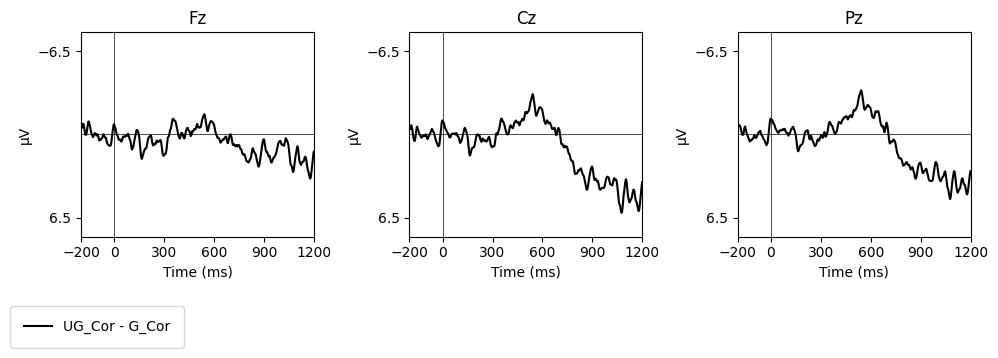

In [12]:
my_plots(diff_evoked_wrapper, layout='Classic ERP',
        ch_to_plot=['Fz','Cz','Pz'], bins_to_plot=['UG_Cor - G_Cor'],
        linestyles=['solid'], colors=['black'],
        nrows=1, ncols=3, figsize=(10,3), xlim=(-200,1200), ylim=(-8,8),
        xticks=[-200,0,300,600,900,1200], yticks=[-6.5,6.5],
        loc='lower left', borderpad=1, bbox_to_anchor=[-0.0001, -0.2], save=False)

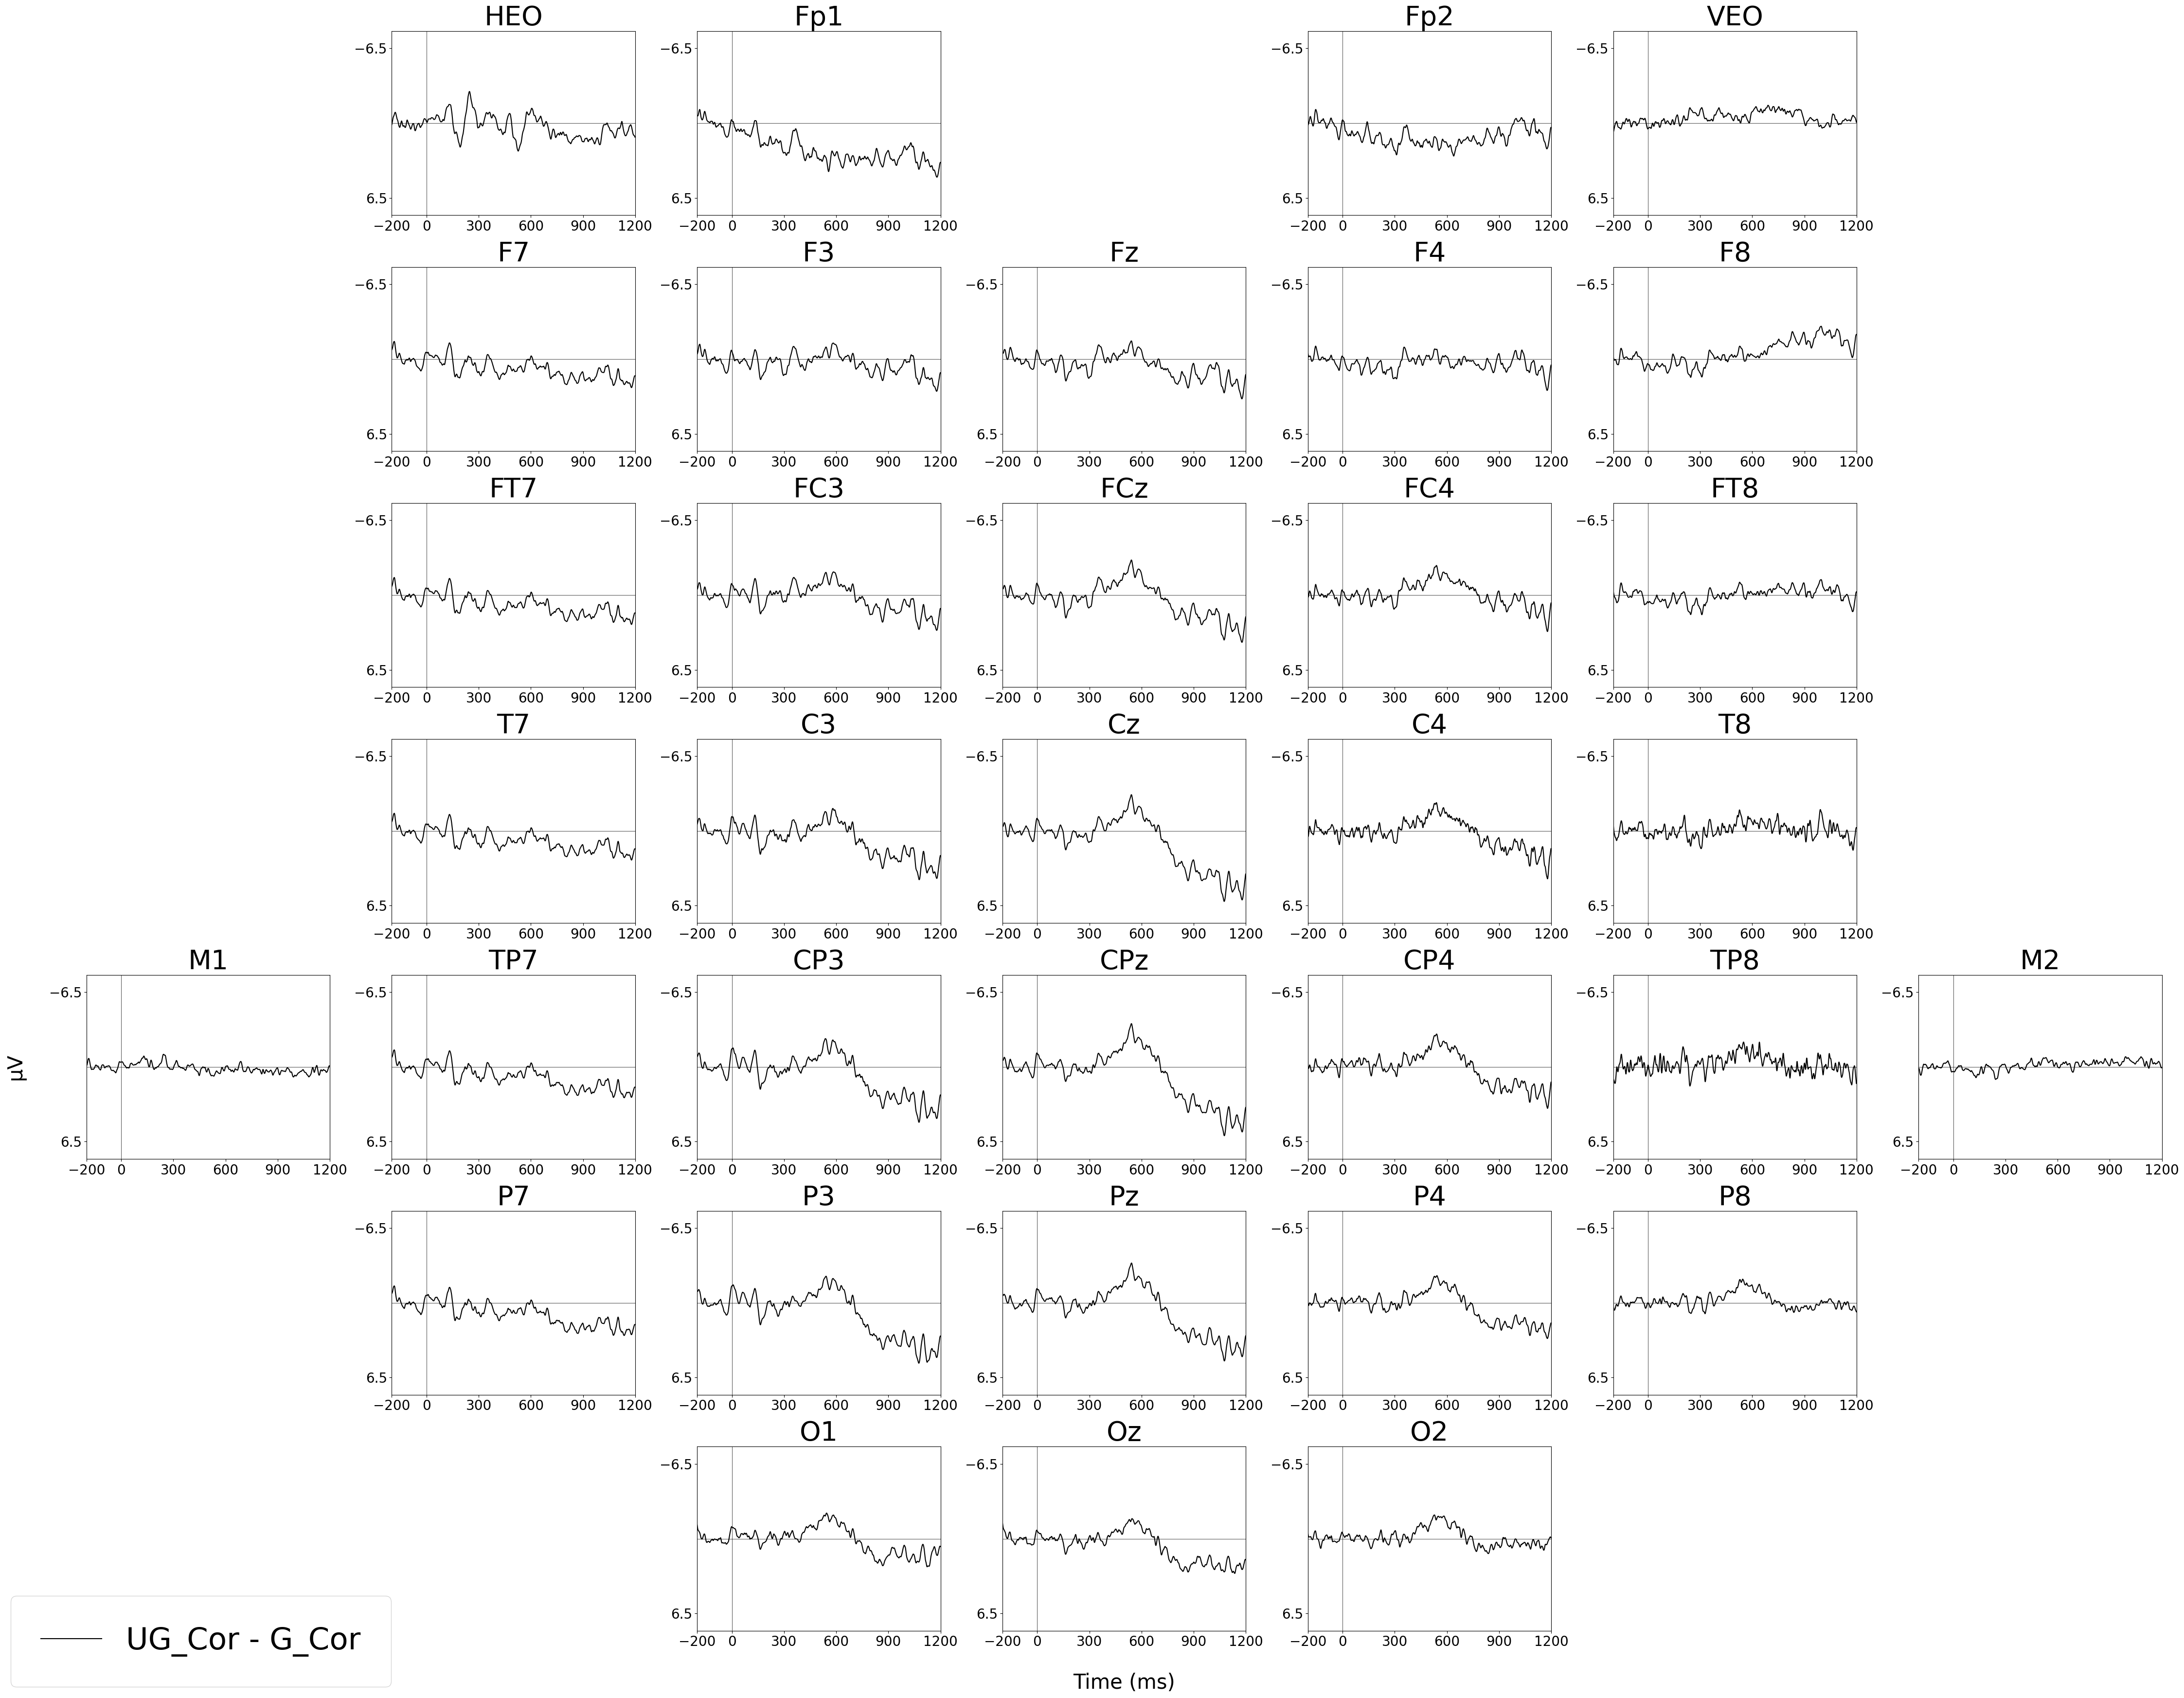

In [13]:
my_plots(diff_evoked_wrapper, layout='Topo', pos_dict=pos_dict, ylabel_pos=28,
         ch_to_plot=ch_to_plot, bins_to_plot=['UG_Cor - G_Cor'],
         linestyles=['solid'], colors=['black'],
         nrows=7, ncols=7, figsize=(45,35), xlim=(-200,1200), ylim=(-8,8),
         xticks=list([-200,0,300,600,900,1200]), yticks=[-6.5,6.5],
         loc='lower left', borderpad=1, bbox_to_anchor=[-0.001, -0.001],
         save=False)

### Difference waves: (Contralateral) - (Ipsilateral)

In [14]:
ch_dict = {}
for i, x in enumerate(diff_evoked_wrapper.ch_names):
    ch_dict[x] = i

contra_ipsi_evoked_wrapper = create_contra_ipsi_evoked_wrapper(diff_evoked_wrapper, 
                                                               bins_to_compare=['All_RVF_Cor', 'All_LVF_Cor'],
                                                               groups={'TP7-TP8': [ch_dict['TP7'], ch_dict['TP8']],
                                                                       'TP8-TP7': [ch_dict['TP8'], ch_dict['TP7']]})

In [15]:
contra_ipsi_evoked_wrapper.ch_names

['TP7-TP8', 'TP8-TP7']

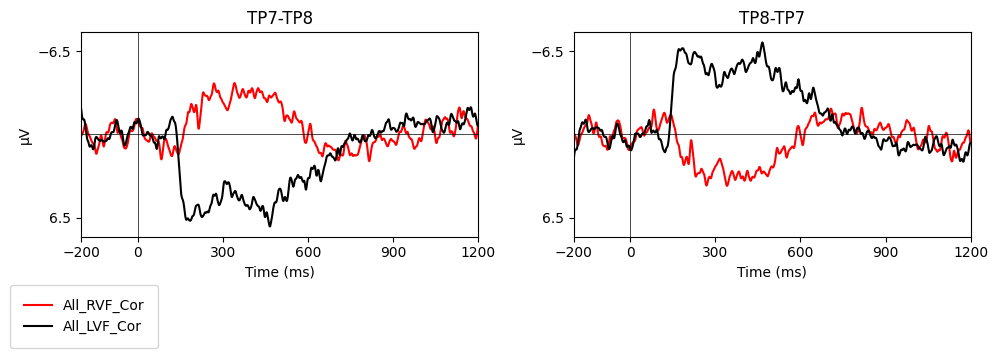

In [16]:
my_plots(contra_ipsi_evoked_wrapper, layout='Classic ERP',
        ch_to_plot=contra_ipsi_evoked_wrapper.ch_names,
        bins_to_plot=list(contra_ipsi_evoked_wrapper.bins.keys()),
        linestyles=['solid','solid'], colors=['red','black'],
        nrows=1, ncols=2, figsize=(10,3), xlim=(-200,1200), ylim=(-8,8),
        xticks=[-200,0,300,600,900,1200], yticks=[-6.5,6.5],
        loc='lower left', borderpad=1, bbox_to_anchor=[-0.0001, -0.2], save=False)

### Topo maps: (Ungrammatical Correct) - (Grammatical Correct)

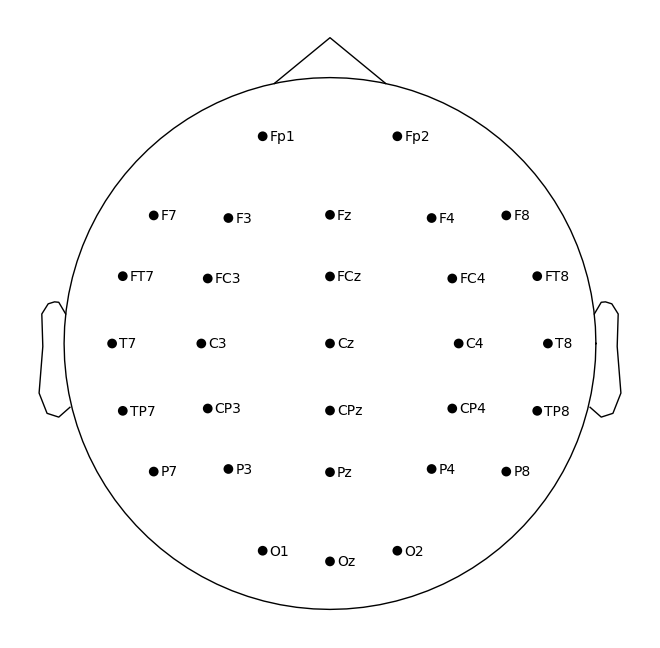

In [17]:
# Cutting off the 200-ms baseline; scale by 1e-06
diff_data = 1e-06*diff_evoked_wrapper.data[diff_evoked_wrapper.bins['UG_Cor - G_Cor']][:,200:]
evoked_topo = mne.EvokedArray(data=diff_data, info=info)

montage = evoked_topo.get_montage()
montage.plot();

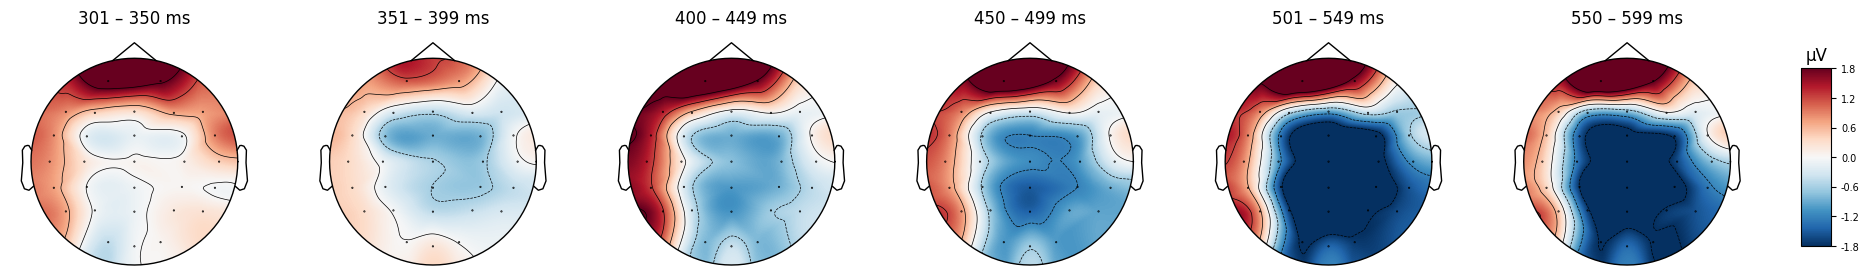

In [18]:
# N400 (300ms - 500ms)
evoked_topo.plot_topomap(times=np.array([325+i*50 for i in range(0,6)])/1000, average=[0.05]*6,
                         vlim=(-1.8,1.8), time_unit='ms', size=2, res=128, mask=None, contours=5);

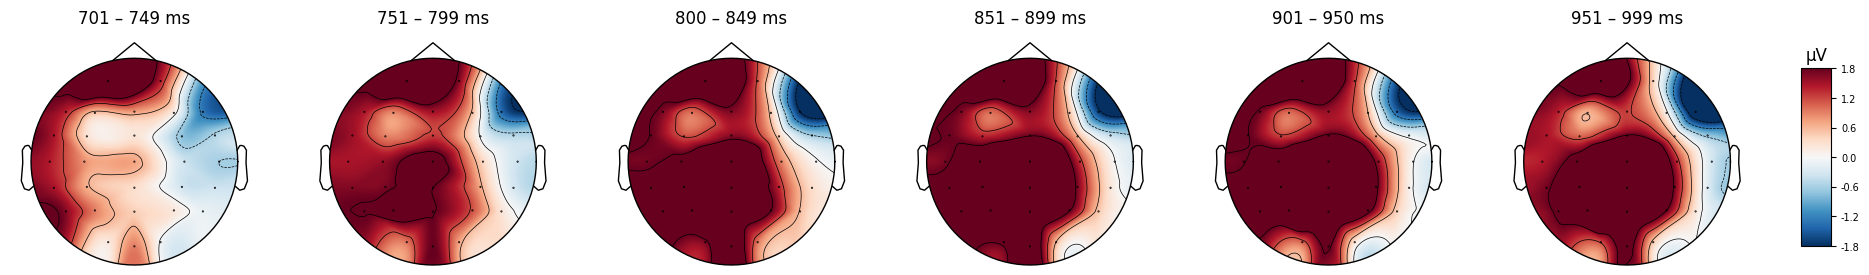

In [19]:
# P600 (700ms - 1000ms)
evoked_topo.plot_topomap(times=np.array([725+i*50 for i in range(0,6)])/1000, average=[0.05]*6,
                          time_unit='ms', vlim=(-1.8, 1.8), size=2, res=128, mask=None, contours=5);

### Exercise: Grand Average? 